In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import mean_squared_error

In [2]:
data_train = pd.read_csv("NASADataset/train_FD001.txt", sep=r"\s+", header=None)
data_test = pd.read_csv("NASADataset/test_FD001.txt", sep=r"\s+", header=None)
data_RUL = pd.read_csv("NASADataset/RUL_FD001.txt", header=None)

# column headers based on kaggle
columns_train = ['unit_ID', 'cycles', 'setting_1', 'setting_2', 'setting_3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc',
                 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB',
                 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
data_train.columns = columns_train
data_test.columns = columns_train

0        1
1        2
2        3
3        4
4        5
      ... 
187    188
188    189
189    190
190    191
191    192
Name: cycles, Length: 192, dtype: int64


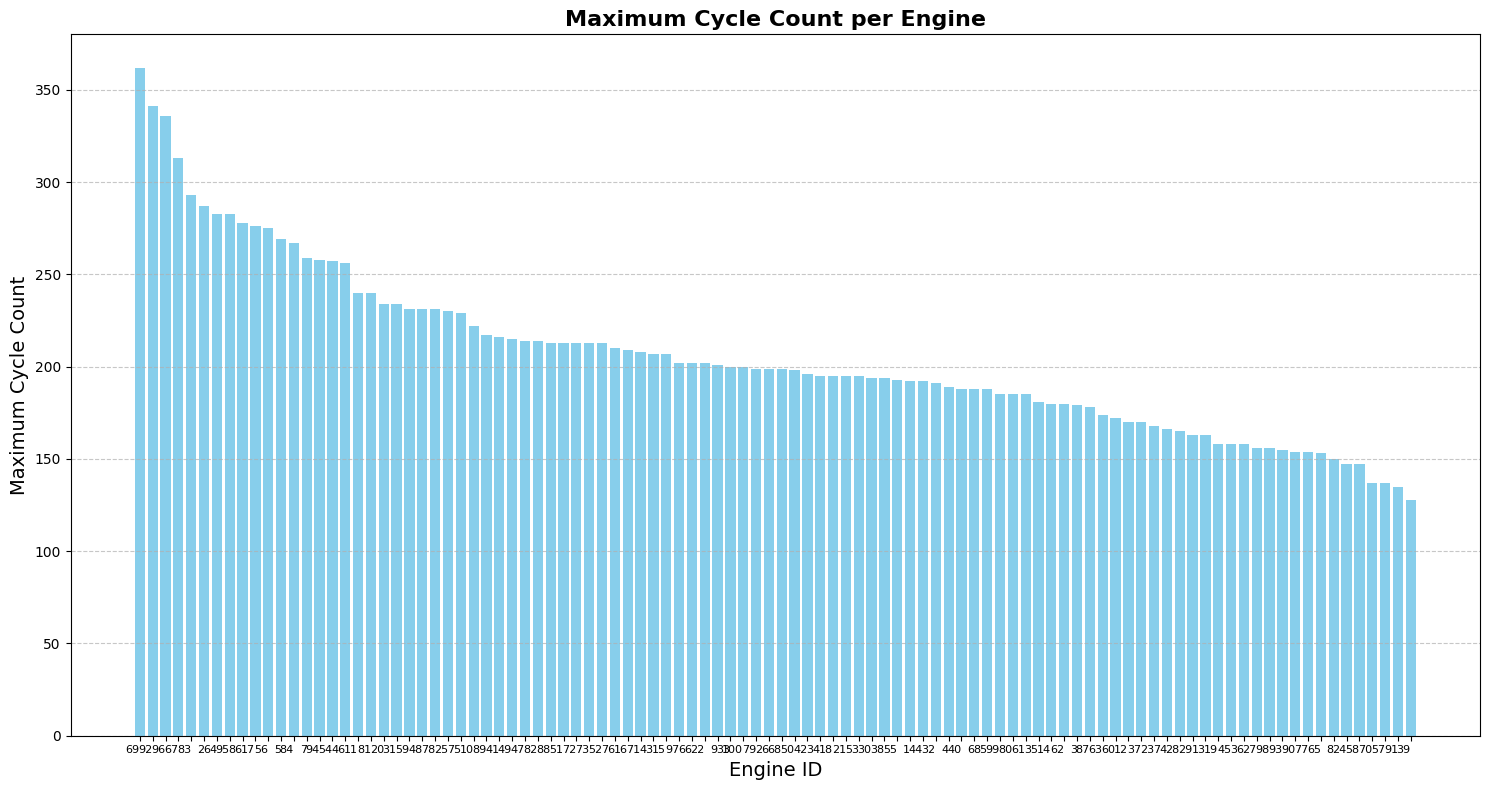

In [3]:
# Get the maximum cycle per engine ID
CT = data_train[['unit_ID', 'cycles']].groupby("unit_ID", as_index=False).max()
CT = CT.sort_values(by="cycles", ascending=False)

# just a visualzier for engine 1
engine_1_cycles = data_train[data_train['unit_ID'] == 1]['cycles']
print(engine_1_cycles)

# Prepare data for plotting
index = CT['unit_ID'].astype(str).tolist()
values = CT['cycles'].tolist()

plt.figure(figsize=(15, 8))  
plt.bar(index, values, color='skyblue')

# labels and title
plt.xlabel('Engine ID', fontsize=14)
plt.ylabel('Maximum Cycle Count', fontsize=14)
plt.title('Maximum Cycle Count per Engine', fontsize=16, fontweight='bold')
plt.xticks(fontsize=8, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [4]:
scaler = StandardScaler()

columns_to_be_dropped = ['unit_ID', 'setting_1'] # we don't need the id number and time in cycles as part of the features since they are labels
train_data_first_column = data_train["unit_ID"]
test_data_first_column = data_test["unit_ID"]

train_data = scaler.fit_transform(data_train.drop(columns=columns_to_be_dropped))
test_data = scaler.transform(data_test.drop(columns=columns_to_be_dropped))

train_data = pd.DataFrame(data=np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data=np.c_[test_data_first_column, test_data])

In [5]:
def add_rul(g):
    g['RUL'] = max(g['cycles']) - g['cycles']
    return g

data_train = data_train.groupby('unit_ID').apply(add_rul)

def process_targets(data_length): #make an array of RUL values for window
    return np.arange(data_length - 1, -1, -1)



C:\Users\jason\AppData\Local\Temp\ipykernel_3076\1604022290.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_train = data_train.groupby('unit_ID').apply(add_rul)


In [6]:
def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    #window maker 
    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats=num_batches * window_length * num_features).reshape(
        num_batches, window_length, num_features
    )

    if target_data is None:
        # Only create sequences without targets
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
        return output_data
    else:
        # Create sequences with corresponding targets
        output_targets = np.repeat(np.nan, repeats=num_batches)
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
            output_targets[batch] = target_data[(shift * batch + (window_length - 1))]
        return output_data, output_targets


In [7]:
window_length = 30
shift = 1

processed_train_data = []
processed_train_targets = []

for i in np.arange(1, len(train_data[0].unique()) + 1):  # Iterate over unique engine IDs
    temp_train_data = train_data[train_data[0] == i].drop(columns=[0]).values  # Filter data for engine `i`

    if len(temp_train_data) < window_length:
        raise ValueError(f"Train engine {i} doesn't have enough data for the window length.")
    
    temp_train_targets = process_targets(data_length=len(temp_train_data))  # RUL as a countdown
    
    # Create sliding windows and associate them with RUL targets
    data_for_machine, targets_for_machine = process_input_data_with_targets(
        temp_train_data,
        temp_train_targets,
        window_length=window_length,
        shift=shift
    )
    
    processed_train_data.append(data_for_machine)
    processed_train_targets.append(targets_for_machine)

# Combine all processed data and targets across engines
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

print(f"Processed Train Data Shape: {processed_train_data.shape}")
print(f"Processed Train Targets Shape: {processed_train_targets.shape}")



Processed Train Data Shape: (17731, 30, 24)
Processed Train Targets Shape: (17731,)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets,
                                                  test_size=0.2, random_state=83)
print("Processed train data shape: ", X_train.shape)
print("Processed validation data shape: ", X_val.shape)


Processed train data shape:  (14184, 30, 24)
Processed validation data shape:  (3547, 30, 24)


In [9]:
def process_test_data(test_data_for_an_engine, window_length=30, shift=1, num_test_windows=1):
    """
    Create sliding windows for test data.
    """
    max_num_windows = (len(test_data_for_an_engine) - window_length) // shift + 1
    if max_num_windows < num_test_windows:
        num_test_windows = max_num_windows
    start_idx = -(num_test_windows - 1) * shift - window_length
    return process_input_data_with_targets(test_data_for_an_engine[start_idx:], window_length=window_length, shift=shift), num_test_windows



In [10]:
processed_test_data = []
num_test_windows = 5
num_test_windows_list = []

for i in np.arange(1, len(test_data[0].unique()) + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns=[0]).values
    test_data_for_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift=shift,
                                                          num_test_windows=num_test_windows)
    processed_test_data.append(test_data_for_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)


In [11]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Convert test data to tensor
X_test_tensor = torch.tensor(processed_test_data, dtype=torch.float32)

# Create a test dataset
test_dataset = TensorDataset(X_test_tensor)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [12]:
class RULPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(RULPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 96)
        self.fc2 = nn.Linear(96, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Pass through LSTM layers
        lstm_out, _ = self.lstm(x)
        # Take only the last time step's output
        out = lstm_out[:, -1, :]
        # Fully connected layers
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# Hyperparameters
input_dim = 24  # Number of features
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.5
batch_size = 128
learning_rate = 0.001
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize model, loss function, optimizer, and scheduler
model = RULPredictor(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Custom learning rate scheduler (matches TensorFlow scheduler)
def lr_scheduler(epoch):
    if epoch < 5:
        return 1.0  # Keep learning rate unchanged
    else:
        return 0.1  # Reduce learning rate by 10x

scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)

# Training and validation loop
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Adjust learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")




Epoch 1/50, Train Loss: 6455.9813, Val Loss: 3910.3256
Epoch 2/50, Train Loss: 3824.5639, Val Loss: 3891.1782
Epoch 3/50, Train Loss: 3830.9332, Val Loss: 3888.8378
Epoch 4/50, Train Loss: 2723.9963, Val Loss: 1389.6961
Epoch 5/50, Train Loss: 1301.0681, Val Loss: 1288.3563
Epoch 6/50, Train Loss: 1230.0029, Val Loss: 1213.3073
Epoch 7/50, Train Loss: 1200.9037, Val Loss: 1188.4668
Epoch 8/50, Train Loss: 1160.0007, Val Loss: 1139.6531
Epoch 9/50, Train Loss: 1111.2184, Val Loss: 1086.1186
Epoch 10/50, Train Loss: 1055.1322, Val Loss: 1041.5980
Epoch 11/50, Train Loss: 984.9075, Val Loss: 936.9893
Epoch 12/50, Train Loss: 980.0678, Val Loss: 939.2457
Epoch 13/50, Train Loss: 940.3676, Val Loss: 884.0643
Epoch 14/50, Train Loss: 909.5584, Val Loss: 883.6163
Epoch 15/50, Train Loss: 894.2779, Val Loss: 851.6250
Epoch 16/50, Train Loss: 879.3293, Val Loss: 854.4961
Epoch 17/50, Train Loss: 873.3751, Val Loss: 829.9680
Epoch 18/50, Train Loss: 885.5876, Val Loss: 844.2001
Epoch 19/50, Trai

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Create test loader
test_loader = DataLoader(
    torch.tensor(processed_test_data, dtype=torch.float32),
    batch_size=batch_size
)

# Predict on test data
model.eval()
preds = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).squeeze().cpu().numpy()
        preds.append(y_pred)

# Combine predictions for all test engines
preds = np.concatenate(preds, axis=0)

# Split predictions by engine
preds_for_each_engine = np.split(preds, np.cumsum(num_test_windows_list)[:-1])

# Weighted average for each engine
mean_pred_for_each_engine = [
    np.average(ruls_for_each_engine, weights=np.repeat(1 / num_windows, num_windows))
    for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)
]

# RMSE for averaged predictions
rmse = np.sqrt(mean_squared_error(data_RUL, mean_pred_for_each_engine))
print("RMSE (Averaged predictions):", rmse)

# RMSE using last predictions for each engine
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
rmse_last = np.sqrt(mean_squared_error(data_RUL, preds_for_last_example))
print("RMSE (Last predictions):", rmse_last)


RMSE (Averaged predictions): 28.081326955212237
RMSE (Last predictions): 28.059111188758724


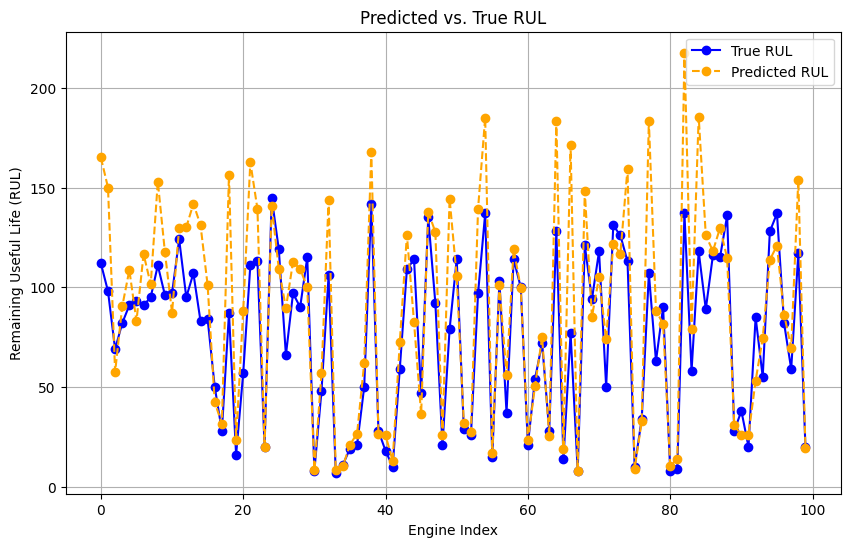

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions and true RUL are aligned
assert len(mean_pred_for_each_engine) == len(data_RUL), "Mismatch in the number of predictions and true RUL values."

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data_RUL, label='True RUL', marker='o', color='blue', linestyle='-')  # Actual RUL
plt.plot(mean_pred_for_each_engine, label='Predicted RUL', marker='o', color='orange', linestyle='--')  # Predicted RUL

# Add labels, legend, and grid
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Predicted vs. True RUL')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
